# Paired multi-model analysis

Here we will use 10X PBMCs scRNA-seq dataset from scanpy as an example to illustrate how Garfield performs scRNA-seq clustering analysis

In [1]:
import os
os.chdir('/data2/zhouwg_data/project/Garfield')
os.getcwd()

'/data2/zhouwg_data/project/Garfield'

In [2]:
# load packages
import os
import warnings
import Garfield as gf
import scanpy as sc
from mudata import MuData
warnings.simplefilter(action="ignore", category=FutureWarning)

gf.__version__

'0.3.1'

In [3]:
## load data
rna = sc.read_h5ad('/home/zhouweige/zhouwg_data/project/Garfield_tutorials/data/human_pbmc_10x_3k_RNA.h5ad')
rna.layers['counts'] = rna.X.copy()
rna.obs['batch'] = 'RNA'
atac = sc.read_h5ad('/home/zhouweige/zhouwg_data/project/Garfield_tutorials/data/human_pbmc_10x_3k_ATAC.h5ad')
atac.layers['counts'] = atac.X.copy()
atac.obs['batch'] = 'ATAC'

# split each element for gene score calculation
split_data = atac.var_names.str.split('-', expand=True).to_frame(index=False)
split_data.index = atac.var_names
split_data.columns = ['chr', 'start', 'end']
atac.var[['chr', 'start', 'end']] = split_data

mdata = MuData({"rna": rna, "atac": atac})
mdata

MuData object with n_obs × n_vars = 2590 × 134920
  var:	'gene'
  2 modalities
    rna:	2590 x 36601
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'nCount_peaks', 'nFeature_peaks', 'RNA_snn_res.1', 'seurat_clusters', 'celltype', 'RNA.weight', 'peaks.weight', 'batch'
      var:	'gene'
      layers:	'counts'
    atac:	2590 x 98319
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'nCount_peaks', 'nFeature_peaks', 'RNA_snn_res.1', 'seurat_clusters', 'celltype', 'RNA.weight', 'peaks.weight', 'batch'
      var:	'gene', 'chr', 'start', 'end'
      layers:	'counts'

# Perform single-cell multi-omics integration using Garfield

For integration of multi-omics single-cell data, we should adjust the following paremeters,
and all parameter introductions can be found in [Garfield_Model_Parameters](https://github.com/zhou-1314/Garfield/blob/main/Garfield_Model_Parameters.md).

In [4]:
# set workdir
workdir = '/home/zhouweige/zhouwg_data/project/Garfield_tutorials/result/garfield_multiome_10xpbmc3k'
gf.settings.set_workdir(workdir)

### modify parameter
user_config = dict(
    ## Input options
    adata_list=mdata, 
    profile='multi-modal',   # if it is 'ATAC' or 'ADT', please adjust it.
    data_type='Paired',
    sub_data_type=['rna', 'atac'],
    sample_col=None,  # Specify columns for batch, only one batch, so set `None`
    weight=0.8,

    ## Preprocessing options
    genome='hg38',
    use_gene_weight=True,
    use_top_pcs=False,
    used_hvg=True,
    min_cells=3,
    min_features=0,
    keep_mt=False,
    target_sum=1e4,
    rna_n_top_features=3000,
    atac_n_top_features=10000, # if data belongs to 'ATAC', please specify it.
    n_components=50,
    n_neighbors=5,
    metric='euclidean',  
    svd_solver='arpack',
    # datasets
    adj_key='connectivities',
    
    # data split parameters
    edge_val_ratio=0.1,
    edge_test_ratio=0.,
    node_val_ratio=0.1,
    node_test_ratio=0.,

    ## Model options
    augment_type='svd',
    svd_q=5,
    use_FCencoder=False, 
    conv_type='GATv2Conv', # GAT or GATv2Conv or GCN
    gnn_layer=2,
    hidden_dims=[128, 128],
    bottle_neck_neurons=20,
    cluster_num=20,
    drop_feature_rate=0.2, 
    drop_edge_rate=0.2,
    num_heads=3,
    dropout=0.2,
    concat=True,
    used_edge_weight=True,
    used_DSBN=False,
    used_mmd=False,
    # data loader parameters
    num_neighbors=5,
    loaders_n_hops=2,
    edge_batch_size=4096,
    node_batch_size=128, # None
    # loss parameters
    include_edge_recon_loss=True,
    include_gene_expr_recon_loss=True,
    lambda_latent_contrastive_instanceloss=1.0,
    lambda_latent_contrastive_clusterloss=0.5,
    lambda_gene_expr_recon=500., # To make the model more focused on learning expression features, increase this parameter.
    lambda_edge_recon=300., # To make the model more focused on learning Adjacency graph features, increase this parameter.
    lambda_omics_recon_mmd_loss=3., # If the integration is not strong enough, increase it.
    # train parameters
    n_epochs_no_edge_recon=0,
    learning_rate=0.001,
    weight_decay=1e-05,
    gradient_clipping=5,
    # other parameters
    latent_key='garfield_latent',
    reload_best_model=True,
    use_early_stopping=True,
    early_stopping_kwargs=None,
    monitor=True,
    seed=2024,
    verbose=True
)
dict_config = gf.settings.set_gf_params(user_config)

Saving results in: /home/zhouweige/zhouwg_data/project/Garfield_tutorials/result/garfield_multiome_10xpbmc3k


In [5]:
from Garfield.model import Garfield

# Initialize model
model = Garfield(dict_config)

--- DATA LOADING AND PREPROCESSING ---


Gene activity matrix has been calculated, and loading cached adata_CG_atac object...
There are 16299 common genes in RNA and ATAC datasets
To start performing cell matching for adjacency matrix of the graph, please wait...
Init_matching done!
Refined_matching done!
Filter_bad_matches on pivots matching...
Begin filtering...
1813/2590 pairs of matched cells remain after the filtering.
Fitting CCA on pivots...
Scoring matched pairs...
Done!
Filter_bad_matches on propagated matching...
Begin filtering...
1554/1554 pairs of matched cells remain after the filtering.
Fitting CCA on pivots...
Scoring matched pairs...
COSINE SIM GRAPH DECODER -> dropout_rate: 0.2


In [6]:
# Train model
model.train()


--- INITIALIZING TRAINER ---


Number of training nodes: 2331
Number of validation nodes: 259
Number of training edges: 17189
Number of validation edges: 1909
Edge batch size: 4096
Node batch size: 128

--- MODEL TRAINING ---
Epoch 1/100 |--------------------| 1.0% val_auroc_score: 0.8162; val_auprc_score: 0.7443; val_best_acc_score: 0.7383; val_best_f1_score: 0.7917; train_kl_reg_loss: 26.5208; train_edge_recon_loss: 210.8099; train_gene_expr_recon_loss: 29522.0988; train_lambda_latent_contrastive_instanceloss: 7.1483; train_lambda_latent_contrastive_clusterloss: 3.7253; train_global_loss: 29770.3035; train_optim_loss: 29770.3035; val_kl_reg_loss: 25.6155; val_edge_recon_loss: 239.5960; val_gene_expr_recon_loss: 25828.3301; val_lambda_latent_contrastive_instanceloss: 7.1309; val_lambda_latent_contrastive_clusterloss: 3.7689; val_global_loss: 26104.4414; val_optim_loss: 26104.4414
Epoch 2/100 |--------------------| 2.0% val_auroc_score: 0.8119; val_auprc_score: 0.7421; val_best_acc_score: 0.7745; val_best_f1_score: 

In [7]:
# Compute latent neighbor graph
latent_key = 'garfield_latent'
sc.pp.neighbors(model.adata,
                use_rep=latent_key,
                key_added=latent_key)
# Compute UMAP embedding
sc.tl.umap(model.adata,
           neighbors_key=latent_key)

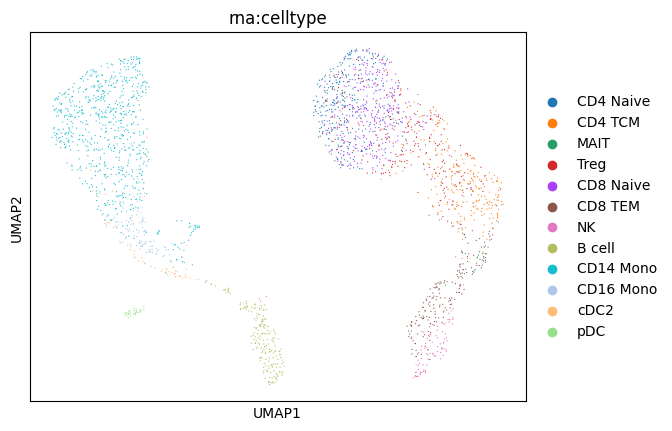

In [8]:
sc.pl.umap(model.adata, color=['rna:celltype'], show=True, size=3) 

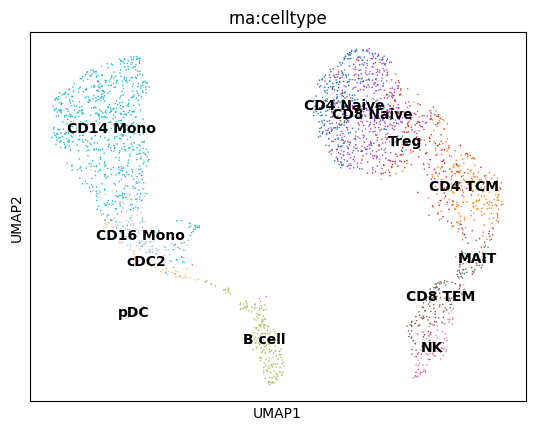

In [9]:
sc.pl.umap(model.adata, color=[ 'rna:celltype'], show=True, size=5, legend_loc='on data') 

In [10]:
# Save trained model
model_folder_path = f"{workdir}/model"
os.makedirs(model_folder_path, exist_ok=True)

model.save(dir_path=model_folder_path,
           overwrite=True,
           save_adata=True,
           adata_file_name="adata_ref.h5ad")

Pickle failed with error: Can't pickle local object 'WeakSet.__init__.<locals>._remove', switching to dill...
Model saved successfully using dill at /home/zhouweige/zhouwg_data/project/Garfield_tutorials/result/garfield_multiome_10xpbmc3k/model/attr.pkl
